Here we propose the way of comparing the local volatility model with stochastic volatility. The setup is the following: 

**1.** We assume that the option prices are given by the Heston model. To generate option prices we use COS method (see *Fang, Fang and Cornelis W. Oosterlee. “A Novel Pricing Method for European Options Based on Fourier-Cosine Series Expansions.” SIAM J. Sci. Comput. 31 (2008): 826-848.*). 


**2.** For a given set of generated option prices we calculate local voaltility using Dupire's formula. 


**3.** Then, we simulate asset paths using local volatility model. In addition, we calculate implied volatilites from LV model and generated by Heston option ptices. 

In [33]:
from COSMethod1D import *
from tqdm import tqdm

In [34]:
@dataclass
class MCParameters:
    number_of_paths: int
    number_of_steps: int

In [35]:
def local_vs_stochastic(heston_parameters: HestonParameters,
                        state: MarketState,
                        is_call: bool,
                        time_to_maturity: float,
                        mc_parameters: MCParameters):
    """
        Compares local and stochastic volatility models.
            
    Args: 
        heston_params (HestonParameters): parameters of Heston model.
        state: MarketState
        is_call: type of option (True if Call, else False)
        time_to_maturity (float or np.array): options time to expiration
        mc_parameters: parameters of Monte Carlo procedure (number of paths and steps)
    """
                            
    # Monte Carlo settings
    NoOfPaths = mc_parameters.number_of_paths
    NoOfSteps = mc_parameters.number_of_steps
    
       
    # Define a function to calculate option prices
    V = lambda T, K: OptionPriceWithCosMethodHelp(is_call, T, K, state, heston_parameters, N=500, L=8)
   
    # Define a shock size for derivative calculation
    delta_T  = 1e-4
    delta_K  = 1e-4
    
    # Define derivatives
    dV_dT   = lambda T,K: (V(T + delta_T, K) - V(T ,K)) / delta_T
    dV_dK   = lambda T,K: (V(T,K + delta_K) - V(T,K - delta_K)) / (2.0 * delta_K)
    d2V_dK2 = lambda T,K: (V(T,K + delta_K) + V(T,K - delta_K) - 2.0*V(T,K))/(delta_K**2.0 )

    # Local variance
    sigmaLV2 = lambda T,K: (dV_dT(T,K) + r * K * dV_dK(T,K)) / (0.5 * K**2.0 * d2V_dK2(T,K))

    # Monte Carlo simulation
    np.random.seed(5)
    dt = time_to_maturity / NoOfSteps
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    S = np.zeros([NoOfPaths, NoOfSteps + 1])
    
    S0 = state.stock_price
    r = state.interest_rate
    S[:,0] = S0
    time = np.zeros([NoOfSteps+1,1])
     
    for i in tqdm(range(0, NoOfSteps)):

        # This condition is necessary as for t=0 we cannot compute implied volatilities
        if time[i]== 0.0:
            time[i] = 0.0001
        
        # Standarize Normal(0,1)
        Z[:,i]=(Z[:,i]-np.mean(Z[:,i]))/np.std(Z[:,i])
        
        # Compute local volatility
        S_i = np.array(S[:,i]).reshape([NoOfPaths,1])
        
        if time[i] > 0 :
            sig = np.real(sigmaLV2(time[i], S_i))
            
        elif time[i]==0:
            sig = np.real(sigmaLV2(dt / 2.0, S_i))
        
        np.nan_to_num(sig)
        
        # Because of discretizations we may encouter negative variance which
        # are set to 0 here.

        sig=np.maximum(sig, 1e-14)
        sigmaLV = np.sqrt(sig.transpose())  
        
        # Stock path
        S[:,i + 1] = S[:,i] * (1.0 + r * dt + sigmaLV * Z[:,i] * np.sqrt(dt))
                       
        # We force that at each time S(t)/M(t) is a martingale
        S[:, i + 1] = S[:, i + 1] - np.mean(S[:, i+1]) + S0 * np.exp(r * (time[i] + dt))
        
        # Make sure that after moment matching we don't encounter negative stock values

        S[:, i+1] = np.maximum(S[:,i + 1],1e-14)
        
        # Adjust time

        time[i + 1] = time[i] + dt
        
    # Plot some results

    K = np.linspace(0.5, 1.7, 50)
    OptPrice = np.zeros([len(K), 1])
    IV_Heston = np.zeros([len(K), 1])
    IV_MC = np.zeros([len(K),1])
    
    # Prices from the Heston model
    valCOS = V(time_to_maturity, K)
    
    # Implied volatilities

    for (idx,k) in enumerate(K):
        OptPrice[idx] = EUOptionPriceFromMCPaths(is_call, S[:,-1], k, time_to_maturity, r)
        IV_MC[idx] = ImpliedVolatility(is_call, OptPrice[idx], k, time_to_maturity, state) * 100.0
        IV_Heston[idx] = ImpliedVolatility(is_call, valCOS[idx], k, time_to_maturity, state) * 100
    
    return S, K, IV_Heston, IV_MC

In [114]:
#heston_parameters = HestonParameters(kappa=1.0,
#                                     gamma=0.4,
#                                     rho=-0.6,
#                                     vbar=0.2,
#                                     v0=0.2)
#heston_parameters = HestonParameters(kappa = 1.3, gamma = 0.3, rho = -0.3, vbar = 0.05, v0 = 0.1)

heston_parameters = HestonParameters(kappa=1.0, gamma=0.4, rho=-0.6, vbar=0.2, v0=0.2)
state = MarketState(stock_price = 1, interest_rate = 0.06, dividends_rate = 0)
mc_parameters = MCParameters(10000, 250) 
maturity = 1

S, K, IV_Heston, IV_MC = local_vs_stochastic(heston_parameters, state, True, maturity, mc_parameters)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:49<00:00,  1.40s/it]


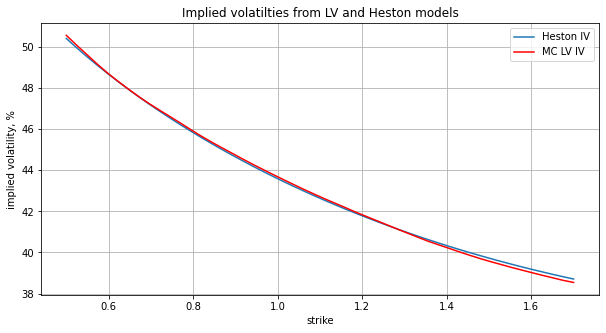

In [115]:
plt.figure(figsize=(10, 5))

plt.title("Implied volatilties from LV and Heston models")

plt.plot(K,IV_Heston)
plt.plot(K,IV_MC,'-r')
plt.grid()
plt.xlabel('strike')
plt.ylabel('implied volatility, %')
plt.legend(['Heston IV','MC LV IV'])
#plt.axis([np.min(K),np.max(K),0,40])
#plt.ylim([25,35])

plt.grid(True)
#plt.savefig('ivls.jpg')

plt.show()

In [123]:
np.random.seed(40)

In [124]:
from heston_simulations import cir_chi_sq_sample, simulate_paths_heston_andersen

In [117]:
time_grid = np.linspace(0.0001, 1, 251)
number_of_paths = mc_parameters.number_of_paths
heston_asset = simulate_paths_heston_andersen(time_grid, number_of_paths, state, heston_parameters)["asset"]

In [125]:
lv_ret1 = (S[:, -1] - S[:, 125]) / S[:, 125]
lv_ret2 = (S[:, -1] - S[:, 190]) / S[:, 190]
lv_ret3 = (S[:, -1] - S[:, 225]) / S[:, 225]

h_ret1 = (heston_asset[:, -1] - heston_asset[:, 125]) / heston_asset[:, 125]
h_ret2 = (heston_asset[:, -1] - heston_asset[:, 190]) / heston_asset[:, 190]
h_ret3 = (heston_asset[:, -1] - heston_asset[:, 225]) / heston_asset[:, 225]

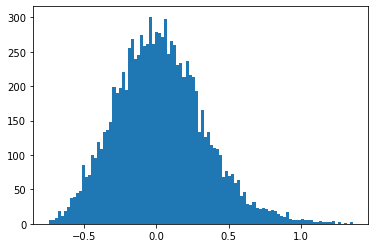

In [126]:
_, ax = plt.subplots()
# ax.hist(S_gt[:, -1], bins=100)
ax.hist(h_ret1, bins=100, range=np.quantile(h_ret1, (.001, .999)))
plt.show()

In [127]:
from statsmodels.distributions.empirical_distribution import ECDF
res_lv1 = ECDF(lv_ret1)
res_lv2 = ECDF(lv_ret2)
res_lv3 = ECDF(lv_ret3)

res_h1 = ECDF(h_ret1)
res_h2 = ECDF(h_ret2)
res_h3 = ECDF(h_ret3)

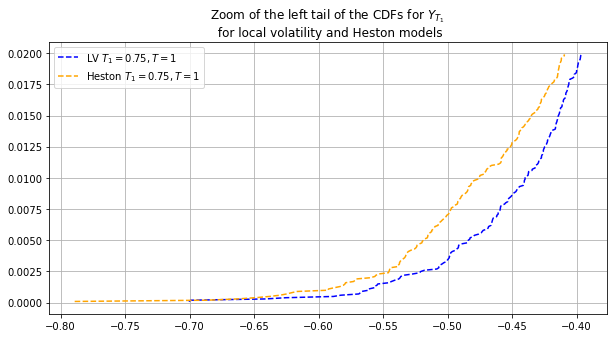

In [128]:
plt.figure(figsize=(10, 5))

idx = 200

plt.title("Zoom of the left tail of the CDFs for $Y_{T_1}$ \n for local volatility and Heston models")

#plt.plot(res_lv1.x[:idx], res_lv1.y[:idx], color="blue", linestyle="-", label="LV $T_1 =0.5, T = 1$")
plt.plot(res_lv2.x[:idx], res_lv2.y[:idx], color="blue", linestyle="--", label="LV $T_1 =0.75, T = 1$")
#plt.plot(res_lv3.x[:idx], res_lv3.y[:idx], color="blue", linestyle=":", label="LV $T_1 = 0.9, T = 1$")


#plt.plot(res_h1.x[:idx], res_h1.y[:idx], color="orange",linestyle="-", label="Heston $T_1 =0.5, T = 1$")
plt.plot(res_h2.x[:idx], res_h2.y[:idx], color="orange",linestyle="--", label="Heston $T_1 =0.75, T = 1$")
#plt.plot(res_h3.x[:idx], res_h3.y[:idx], color="orange",linestyle=":", label="Heston $T_1 =0.9, T = 1$")


plt.grid(True)
plt.legend()
plt.savefig('cdfs.jpg')

plt.show()
